In [25]:
import sqlite3
import os
import polars as pl
import plot
import matplotlib.pyplot as plt
import numpy as np

## Connect + Read from Database

### Set connection parameters

In [68]:
db_dir = "/scratch/aneeshr/concurrent-quit/results/db"
db_name = "db_r_5m_july2"
db_path = db_dir + "/" + db_name

In [69]:
connection = sqlite3.connect(db_path)

### Set the date/timestamp to read

In [70]:
date_to_read = "2025-07-02"

In [29]:
read_index_bench_query = f"SELECT * from index_bench where timestamp > {date_to_read};"

### Read the data

In [71]:
df = pl.read_database(
    query = read_index_bench_query, 
    connection = connection)

### Sample Read Data

In [12]:
filter_col = "index_type"
filter_predicate = "concurrent_quit"

In [13]:
sample_filtered_result = df.filter(pl.col(filter_col) == filter_predicate)

In [24]:
sample_filtered_result

id,timestamp,index_type,workload_file,N,K,L,threads,preload_time,raw_writes_time,raw_reads_time,mixed_time,updates_time,short_range_time,mid_range_time,long_range_time,size,height,internal,leaves,fast_inserts,redistribute,soft_resets,hard_resets,fast_inserts_fail,sort
i64,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
1,"""2025-06-19 00:39:22.912216+00:…","""concurrent_quit""","""5_0_0""",5,0,0,1,834369466,0,0,0,111015322,0,0,0,5000000,2,39,10000,4990000,0,0,0,10000,0
2,"""2025-06-19 00:39:26.764849+00:…","""concurrent_quit""","""5_5_100""",5,5,100,1,1288439722,0,0,0,120119497,0,0,0,5000000,2,52,13982,4579826,0,0,7839,12889,0
3,"""2025-06-19 00:39:31.376638+00:…","""concurrent_quit""","""5_50_100""",5,50,100,1,1886039259,0,0,0,173093891,0,0,0,5000000,2,52,16322,2664612,0,0,19680,9454,0
7,"""2025-06-19 00:39:57.591997+00:…","""concurrent_quit""","""5_0_0""",5,0,0,2,2047258626,0,0,0,210196223,0,0,0,5000000,2,39,9994,4988304,0,0,0,9994,0
8,"""2025-06-19 00:40:03.079715+00:…","""concurrent_quit""","""5_5_100""",5,5,100,2,2882230066,0,0,0,196755886,0,0,0,5000000,2,52,14008,4570923,0,0,7790,12881,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
14,"""2025-06-19 00:40:45.076854+00:…","""concurrent_quit""","""5_5_100""",5,5,100,4,4710735358,0,0,0,245472150,0,0,0,5000000,2,52,14032,4502335,0,0,7829,75202,0
15,"""2025-06-19 00:40:51.770693+00:…","""concurrent_quit""","""5_50_100""",5,50,100,4,3722446202,0,0,0,169452127,0,0,0,5000000,2,51,16310,2656168,0,0,19639,10152,0
19,"""2025-06-19 00:41:28.571417+00:…","""concurrent_quit""","""5_0_0""",5,0,0,8,4390121924,0,0,0,303295833,0,0,0,5000000,2,38,9953,4970478,0,0,0,9953,0


## Analysis

### Preload times

In [40]:
reset_df = df.select(
            pl.col("index_type"),
            pl.col("K"),
            pl.col("threads"),
            pl.col("preload_time"),
            # pl.col("hard_resets")
)
# reset_df = reset_df.filter((pl.col("index_type")=="concurrent_quit_appends") & (pl.col("K")==5))
reset_df = reset_df.filter(((pl.col("index_type")=="concurrent_quit_appends") | 
                            (pl.col("index_type")=="concurrent_quit_atomic")) &
                           (pl.col("K")==50))
print(reset_df)

shape: (8, 4)
┌─────────────────────────┬─────┬─────────┬──────────────┐
│ index_type              ┆ K   ┆ threads ┆ preload_time │
│ ---                     ┆ --- ┆ ---     ┆ ---          │
│ str                     ┆ i64 ┆ i64     ┆ i64          │
╞═════════════════════════╪═════╪═════════╪══════════════╡
│ concurrent_quit_appends ┆ 50  ┆ 1       ┆ 27173255174  │
│ concurrent_quit_atomic  ┆ 50  ┆ 1       ┆ 25465651303  │
│ concurrent_quit_appends ┆ 50  ┆ 2       ┆ 71392421342  │
│ concurrent_quit_atomic  ┆ 50  ┆ 2       ┆ 44628903542  │
│ concurrent_quit_appends ┆ 50  ┆ 4       ┆ 87995105109  │
│ concurrent_quit_atomic  ┆ 50  ┆ 4       ┆ 50276486087  │
│ concurrent_quit_appends ┆ 50  ┆ 8       ┆ 96664655643  │
│ concurrent_quit_atomic  ┆ 50  ┆ 8       ┆ 54074841040  │
└─────────────────────────┴─────┴─────────┴──────────────┘


In [72]:
preload_df = df.select(
                pl.col("index_type"), 
                pl.col("K"),
                pl.col("threads"),
                pl.col("preload_time")
)

In [73]:
num_ops = 5e6
div_factor = num_ops * 1000
preload_df = preload_df.with_columns((div_factor/pl.col("preload_time")).alias("throughput"))
preload_df

index_type,K,threads,preload_time,throughput
str,i64,i64,i64,f64
"""concurrent_quit""",0,1,460245361,10.863771
"""concurrent_quit""",5,1,716883594,6.974633
"""concurrent_quit""",50,1,1052115738,4.752329
"""concurrent_quit_appends""",0,1,392053161,12.753372
"""concurrent_quit_appends""",5,1,547219773,9.137097
…,…,…,…,…
"""concurrent_quit_appends""",5,8,2401380483,2.082136
"""concurrent_quit_appends""",50,8,4952078893,1.009677
"""concurrent_quit_atomic""",0,8,2412883910,2.072209


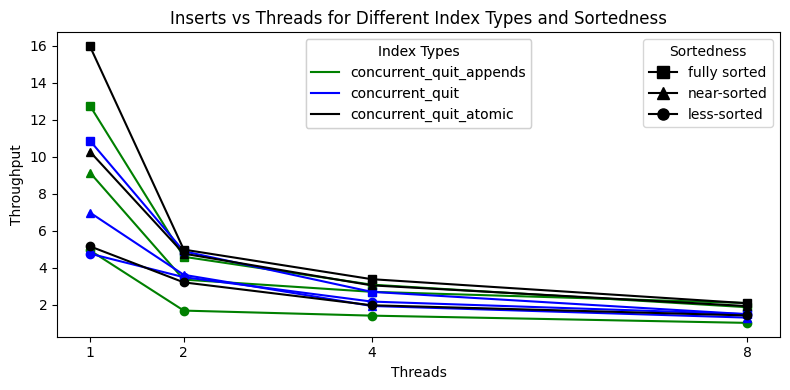

In [74]:
index_types = preload_df["index_type"].unique().to_list()
k_values = sorted(preload_df["K"].unique().to_list())
thread_values = sorted(preload_df["threads"].unique().to_list())

colors = {"concurrent_simple": "grey", "concurrent_quit": "blue", 
          "concurrent_quit_appends": "green", "concurrent_quit_atomic": "black"}
markers = {k: ['s', '^', 'o'][i % 3] for i, k in enumerate(k_values)}
sortedness_values = {0: "fully sorted", 5: "near-sorted", 50: "less-sorted"}

plt.figure(figsize=(8, 4))
lines = []
labels = []
for index in index_types:
    # Filter DataFrame by the current index type
    index_df = preload_df.filter(pl.col("index_type") == index).sort(["K", "threads"])
    # Iterate through each K value
    for k in k_values:
        # Filter DataFrame by the current K value
        k_df = index_df.filter(pl.col("K") == k).sort("threads")
        # Plot preload time against threads for this specific index type and K
        line, =plt.plot(k_df["threads"], k_df["throughput"],
                 label=f'K={k}',
                 color=colors[index],
                 marker=markers[k],
                 linestyle='-')
        lines.append(line)
        labels.append(f'{sortedness_values[k]}')

# Set x-axis ticks and label
plt.xticks(thread_values)
plt.xlabel("Threads")
# Set y-axis label
plt.ylabel("Throughput")
# Set plot title
plt.title("Inserts vs Threads for Different Index Types and Sortedness")
# Add legend

# legend_k_handles = [plt.plot([], [], marker=markers[k], linestyle='-', color='gray', label=f'K={k}')[0] for k in k_values]
# plt.legend(handles=legend_k_handles, title='K Values', loc='upper right')

# # Create a separate legend for Index Types using proxy artists
# legend_index_handles = [plt.plot([], [], color=colors[index], label=f'{index}')[0] for index in index_types]
# plt.legend(handles=legend_index_handles, loc='upper right')

# Create a separate legend for K values (proxy artists)
marker_handles = [plt.Line2D([0], [0], marker=markers[k], color='k', linestyle='-', markersize=8, label=f'{sortedness_values[k]}') for k in k_values]
legend2 = plt.legend(handles=marker_handles, title='Sortedness', loc='upper right')
plt.gca().add_artist(legend2) # Add the second legend to the current axes

# Create a separate legend for Index Types (proxy artists)
color_handles = [plt.Line2D([0], [0], color=colors[index], linestyle='-', label=f'{index}') for index in index_types]
legend3 = plt.legend(handles=color_handles, title='Index Types', loc='upper center')
plt.gca().add_artist(legend3) # Add the third legend to the current axes

# Adjust layout to prevent labels from overlapping
plt.tight_layout()
# Show the plot
# plt.show()
plt.savefig("inserts-r-5m-july2.pdf")

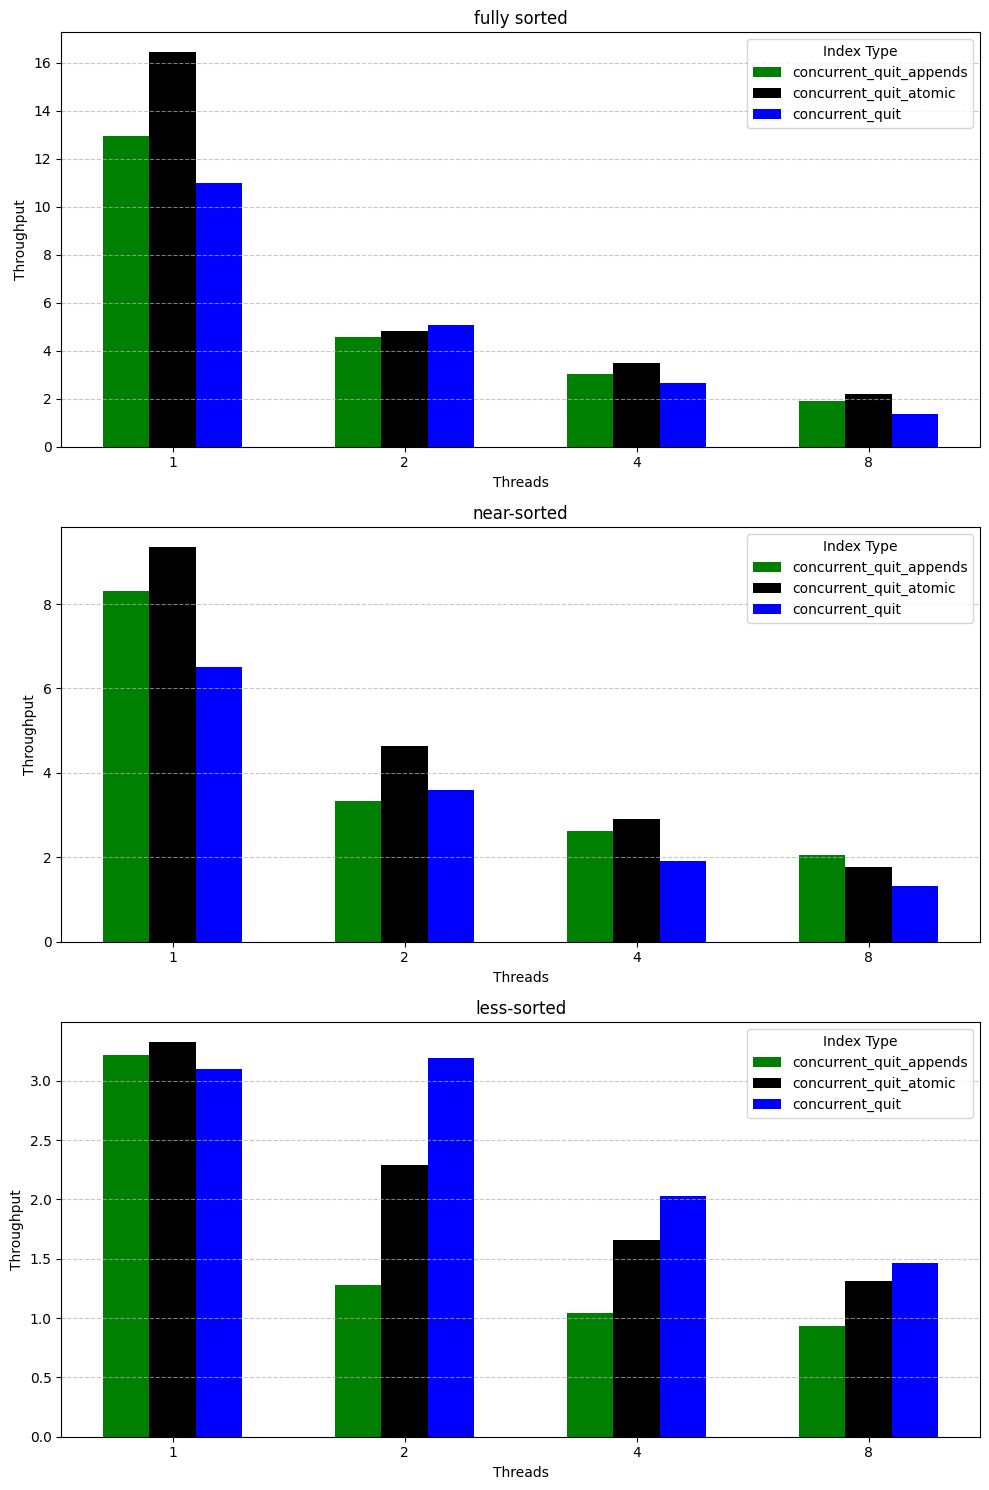

In [67]:
# Create a figure and a set of subplots based on the number of unique K values
fig, axes = plt.subplots(
    nrows=len(k_values),
    ncols=1,
    figsize=(10, 5 * len(k_values)),
    sharex=False
)
# Ensure 'axes' is an array even if there's only one subplot
if len(k_values) == 1:
    axes = [axes]

bar_width = 0.2
# Define colors for each index_type to maintain consistency across subplots
colors_map = {
    "concurrent_simple": "grey",
    "concurrent_quit": "blue",
    "concurrent_quit_appends": "green",
    "concurrent_quit_atomic": "black"
}


for i, k in enumerate(k_values):
    ax = axes[i]
    # Filter DataFrame by the current K value and sort using pandas
    # k_df = preload_df[preload_df["K"] == k].sort_values(by=["index_type", "threads"])
    # preload_df.filter(pl.col("index_type") == index).sort(["K", "threads"])
    k_df = preload_df.filter(pl.col("K") == k).sort(by = ["K", "threads"])

    # Calculate positions for bars for each index_type to avoid overlap
    x = range(len(thread_values))
    num_index_types = len(index_types)
    # The starting offset for the first bar group
    offset_start = -((num_index_types - 1) / 2) * bar_width

    for idx_type_idx, index_type in enumerate(index_types):
        # Calculate the actual positions for the bars of the current index_type
        # These positions are offset from the main x-ticks (thread_values)
        current_x_positions = [
            val + offset_start + idx_type_idx * bar_width
            for val in x
        ]
        # Filter for the current index_type and sort by threads using pandas
        # type_df = k_df[k_df["index_type"] == index_type].sort_values("threads")
        type_df = k_df.filter(pl.col("index_type") == index_type).sort("threads")
        ax.bar(
            current_x_positions,
            type_df["throughput"],
            width=bar_width,
            label=index_type,
            color=colors_map[index_type]
        )

    ax.set_xticks(x)
    ax.set_xticklabels(thread_values)
    ax.set_xlabel("Threads")
    ax.set_ylabel("Throughput")
    ax.set_title(f"{sortedness_values[k]}")
    ax.legend(title="Index Type")
    ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
# plt.show()
plt.savefig("inserts-july2-separate-sortedness.pdf")

# Old

In [20]:
# fetch index types
index_types = df["index_type"].unique().to_list()

# filter and group dfs by index types
grouped_dfs = {}
for index in index_types:
    filtered_df = preload_df.filter(pl.col("index_type") == index).sort("K")
    grouped_dfs[index] = filtered_df

k_values = sorted(preload_df["K"].unique().to_list())

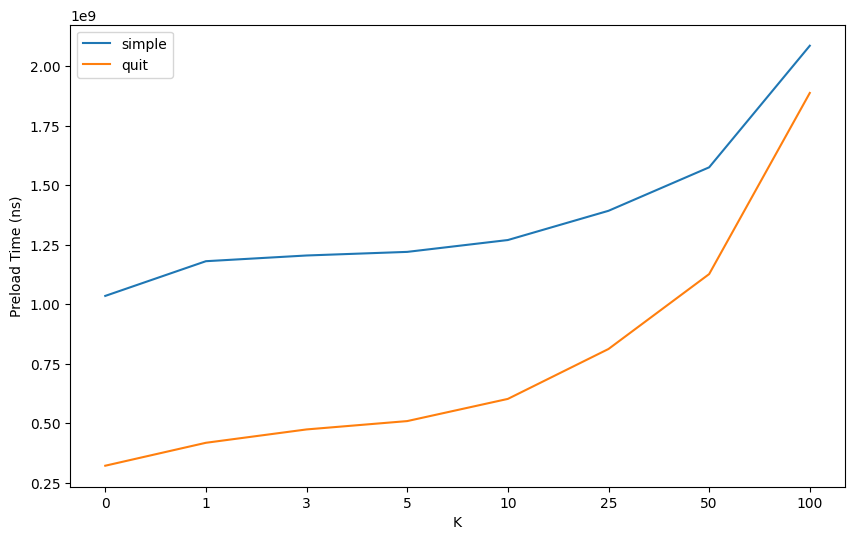

In [21]:
x_positions = np.arange(len(k_values))

plt.figure(figsize=(10,6))

for index, index_df in grouped_dfs.items():
    plt.plot(x_positions, index_df["preload_time"], label=index)

plt.xticks(x_positions, k_values)
plt.xlabel("K")
plt.ylabel("Preload Time (ns)")
plt.legend()
plt.show()